In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import v2


batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [2]:
#load save model
import torch
from vae import VAE  # Assuming the VAE class is defined in vae.py
from vae_output import VAEOutput  # Assuming the VAEOutput class is defined in vae_output.py    
from datetime import datetime

learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

model.load_state_dict(torch.load('vae_mnist.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

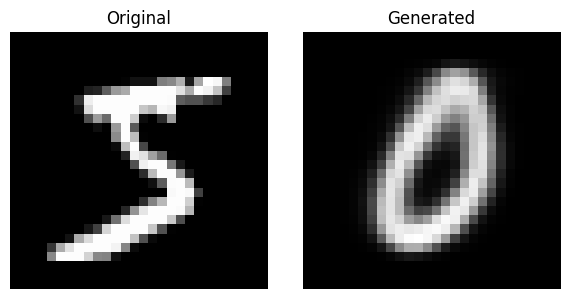

In [ ]:
import matplotlib.pyplot as plt
# Take a single record from the dataset
sample_img, sample_label = train_data[0]
sample_img = sample_img.to(device).view(1, -1)

# 1. Encode: get z distribution and sample z
model.eval()
with torch.no_grad():
    encoded = model(sample_img, compute_loss=False)
    z_encoded = encoded.z_sample  # shape: [1, latent_dim]

# 2. Perturb z (e.g., add small noise)
z_new = z_encoded + torch.randn_like(z_encoded) #* 0.5

# 3. Decode z to generate a new result
with torch.no_grad():
    decoded = model.decode(z_new)
    decoded_img = decoded.view(28, 28).cpu().numpy()

# Plot original and generated images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(sample_img.view(28, 28).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Generated")
plt.imshow(decoded_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()